In [1]:
import pandas as pd

In [2]:
# Data reference: https://www.kaggle.com/datasets/chasebank/bank-deposits

interested_cols = ['Branch Name', 'Street Address',  'City', 'State', 'Zipcode']
df = pd.read_csv("./chase-bank-branch-deposits.csv")
main_br = df.iloc[:1][interested_cols]
mobile_br = pd.DataFrame([["JPMorgan Chase Bank Mobile", None, None, None, None]], columns=interested_cols)
df = df.iloc[1:][interested_cols].sample(24, random_state=4123)

df = pd.concat([main_br, mobile_br, df], ignore_index=True)

df.nunique()

Branch Name       26
Street Address    25
City              25
State             13
Zipcode           25
dtype: int64

In [3]:
df.head()

,Branch Name,Street Address,City,State,Zipcode
0,JPMorgan Chase Bank Main Office,1111 Polaris Parkway,Columbus,OH,43240
1,JPMorgan Chase Bank Mobile,None,None,None,None
2,College Grove Branch,3490 College Avenue,San Diego,CA,92115
3,Athens Main Branch,2 S Court Street,Athens,OH,45701
4,South Salem Branch,3450 Commercial St Se,Salem,OR,97302


In [4]:
def construct_insert_stmt_fmt(value_cnt):
    fmt = "INSERT INTO \{\} VALUES ({});"
    b_str = ", ".join(["{}" for _ in range(value_cnt)])
    stmt_fmt = "INSERT INTO {} VALUES (" + b_str + ");"
    
    return stmt_fmt

def convert_by_type(value):
    if pd.isna(value):
        return 'NULL';
    elif type(value) in [str, bytes]:
        return f"'{value}'"
    elif type(value) in [int, float]:
        return value

def create_single_insert_stmt(table_name, *items):
    insert_stmt_fmt = construct_insert_stmt_fmt(len(items))
    param_l  = [convert_by_type(item) for item in items]
    
    return insert_stmt_fmt.format(table_name, *param_l) + "\n"
    

with open("populate_bank.sql", "w") as f:
    for i, r in df.iterrows():
        f.write(create_single_insert_stmt("BANK", i, r["Branch Name"], r["Street Address"], r["City"], r["State"], r["Zipcode"]))


In [5]:
# Data reference: https://www.kaggle.com/datasets/hemendrasr/name-by-nationality

df = pd.read_csv("./names-by-nationality.csv")
df = df[(df["sex"] != "Neutral") & (df["nationality"] != "African")]
df.nunique()

shuffle = lambda df: df.sample(frac=1, random_state=775, ignore_index=True)

df_american = shuffle(df[df["nationality"] == "American"])[:175]
df_japanese = shuffle(df[df["nationality"] == "Japanese"])[:10]
df_indian = shuffle(df[df["nationality"] == "Indian"])[:9]
df_french = shuffle(df[df["nationality"] == "French"])[:4]
df_german = shuffle(df[df["nationality"] == "German"])[:2]

map_list_a = [(12, 99), (45, 67), (33, 46), (65, 172), (7, 160), (11, 77), (97, 133)]
map_list_i = [(3, 6)]

def create_duplicate_names(df, map_l): 
    for from_i, to_i in map_l:
        df.iloc[to_i]["name"] = df.iloc[from_i]["name"]
        df.iloc[to_i]["sex"] = df.iloc[from_i]["sex"]

create_duplicate_names(df_american, map_list_a)
create_duplicate_names(df_indian, map_list_i)

df = pd.concat([df_american, df_japanese, df_indian, df_french, df_german]).sample(frac=1, random_state=775, ignore_index=True)

df.head()

,name,sex,nationality
0,Jainna,Female,American
1,Tyrion,Male,American
2,Annaleigh,Female,American
3,Arlene,Female,American
4,Tsukiko,Female,Japanese


In [6]:
import requests
from bs4 import BeautifulSoup
import sys

def get_addr_list(soup):
    uls = soup.find_all("ul", class_="list-unstyled")

    for ul in uls:
        b = ul.find("b")
        if b is not None and "Street:" in b:
            addr_ul = ul
            break

    addr_list = addr_ul.find_all("li")
    addr_dicts = []
    for address in addr_list:
        addr_dict = {}
        keys = ["street", "city", "state", "phone_number"]
        for s, k in zip(address.find_all("span")[:4], keys):
            text = s.find("b").nextSibling.get_text().strip()
            addr_dict[k] = text
        addr_dicts.append(addr_dict)

    return addr_dicts

In [7]:
# Data reference: https://www.bestrandoms.com/random-address-in-us

addr_list = []
for _ in range(10):
    try:
        res = requests.get("https://www.bestrandoms.com/random-address-in-us?quantity=20")
        res.raise_for_status()
    except Exception as e:
        print(e)
        sys.exit(1)

    html_doc = res.text
    soup = BeautifulSoup(html_doc, "html.parser")
    addr_list.extend(get_addr_list(soup))
addr_list[0]

{'street': '4651 Trainer Avenue',
 'city': 'Peoria',
 'state': 'Illinois',
 'phone_number': '309-518-7596'}

In [8]:
def to_addr(**d):
    return ", ".join([d["street"], d["city"], d["state"]])  

addr_list = [{"address": to_addr(**addr), "phone_number": addr["phone_number"]}for addr in addr_list]
addr_list[0]

{'address': '4651 Trainer Avenue, Peoria, Illinois',
 'phone_number': '309-518-7596'}

In [9]:
with open("populate_holder.sql", "w") as f:
    for addr, (i, r) in zip(addr_list, df.iterrows()):
        insert_stmt = create_single_insert_stmt("HOLDER", i, r["name"], r["sex"], addr["address"], r["nationality"], addr["phone_number"])
        f.write(insert_stmt)
    

In [10]:
import random

dng_holder_ids = list(range(200))
random.shuffle(dng_holder_ids)
dng_holder_ids = dng_holder_ids[:20]
dng_scores = [round(random.uniform(90, 99), 2) for _ in range(20)]

with open("populate_dng_holder.sql", "w") as f:
    for h_id, score in zip(dng_holder_ids, dng_scores):
        insert_stmt = create_single_insert_stmt("DNG_HOLDER", h_id, score)
        f.write(insert_stmt)

In [11]:
from functools import reduce

mapper = [(1, 185), (2, 10), (5, 2), (9, 1), (10, 2)]
uniq_h_ids = list(range(200))
random.shuffle(uniq_h_ids)

print(uniq_h_ids[:7])
h_ids = []

def red_func(prev, curr):
    t = uniq_h_ids[prev[1]:prev[1]+curr[1]]
    t = [e for e in t for _ in range(curr[0])]
    h_ids.extend(t)

    return curr

reduce(red_func, mapper, (0, 0))
account_cnt = sum(m[0] * m[1] for m in mapper)
print(len(h_ids), account_cnt)

[65, 43, 60, 71, 22, 120, 150]
244 244


2909601 3036


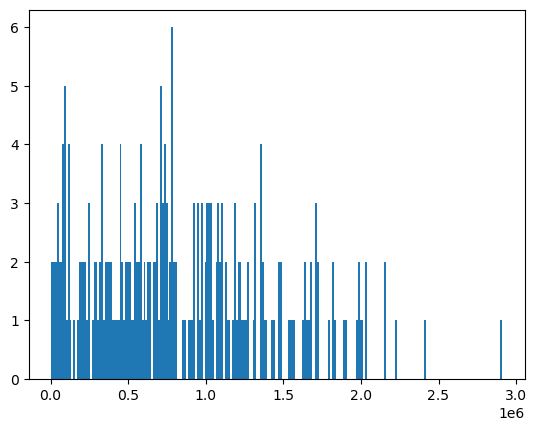

In [12]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(521)
bals = list(abs(np.random.normal(774000, 700000, 244)).astype(int))
plt.hist(bals, bins=len(bals))
print(max(bals), min(bals))
plt.show()

In [13]:
import string
characters = string.ascii_letters + string.punctuation  + string.digits

def gen_pwd():
    password = ""
    password_length = random.randint(8, 16)

    for x in range(password_length):
        char = random.choice(characters)
        password = password + char
    
    return password


In [14]:
pwd_list = [gen_pwd() for _ in range(account_cnt)]

In [15]:
import json

with open("./dng_account_list.json", "r") as f:
    dng_account_list = json.load(f)["dng_account_list"]

prefix_digits = list(set(d[:3] for d in dng_account_list))

def n_len_rand(n):
    a = [str(random.randrange(0, 10)) for _ in range(n)]
    return "".join(a)

def gen_account():
    i = random.randrange(0, len(prefix_digits))
    return str(prefix_digits[i]) + n_len_rand(9)

account_list = []
while True:
    accnt = gen_account()
    if accnt in dng_account_list:
        continue
    account_list.append(accnt)
    if len(account_list) == account_cnt:
        break


In [16]:
import csv

with open("account_pwd_map.csv", "w", newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for a, p in zip(account_list, pwd_list):
        writer.writerow([a, p])


In [17]:
import hashlib

m = hashlib.sha256()

with open("populate_account.sql", "w") as f:
    for acc_no, bal, pwd, h_id in zip(account_list, bals, pwd_list, h_ids):
        m.update(pwd.encode("utf-8"))
        f.write(create_single_insert_stmt("ACCOUNT", acc_no, int(bal), m.digest().hex(), h_id))